In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qc_simulator import QuantumCircuit

## Two Qubit system (Example 1)

In [2]:
# Basic Quantum circuit to obtain Entanglement

circuit1 = QuantumCircuit(nqubits=2)

qcircuit = [{ "gate": "H", "target": [0] },
            { "gate": "CNOT", "target": [0,1] }]
            
initial_state = circuit1.get_groundstate()
print(f'Initial State :\n {initial_state}')

final_state = circuit1.get_finalstate(qcircuit,initial_state)
print(f'\nFinal state:\n {final_state}')

# use help(QuantumCircuit) for docs

Initial State :
 [[1.]
 [0.]
 [0.]
 [0.]]

Final state:
 [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]


In [3]:
results = circuit1.get_counts(final_state,shots=1000)  # obtain measurement results
print('\nMeasurement Results:',results)


Measurement Results: {'|00>': 495, '|11>': 505}


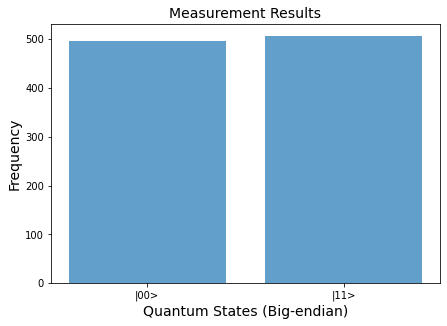

In [4]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results.keys(), results.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()

## Two Qubit system (Example 2)

In [5]:
# A random Quantum Circuit

qcircuit2 = [{ "gate": "H", "target": [0] },
            { "gate": "CNOT", "target": [0,1] },
            { "gate": "Y", "target": [0] },
            { "gate": "H", "target": [1] },
            { "gate": "CNOT", "target": [1,0] },
            { "gate": "Z", "target": [1] },
            { "gate": "S", "target": [1] },
           { "gate": "T", "target": [1] },
           ]

In [6]:
circuit2 = QuantumCircuit(2)
initial_state2 = (1/2)*np.ones((4,1)) #different from ground state
final_state2 = circuit2.get_finalstate(qcircuit2,initial_state) 


print(f'Initial State :\n {initial_state2}')
print(f'\nFinal state (after normalization):\n {final_state2}')

Initial State :
 [[0.5]
 [0.5]
 [0.5]
 [0.5]]

Final state (after normalization):
 [[ 0.        -0.5j       ]
 [-0.35355339-0.35355339j]
 [ 0.        +0.5j       ]
 [-0.35355339-0.35355339j]]


In [7]:
results2 = circuit2.get_counts(final_state2,shots=1000)  # obtain measurement results

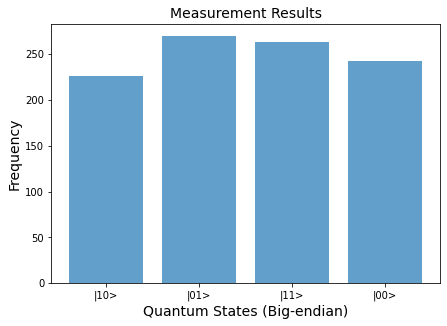

In [8]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results2.keys(), results2.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()

## Three Qubit System

In [9]:
# A random Quantum Circuit

qcircuit3 = [{ "gate": "H", "target": [0] },
            { "gate": "H", "target": [1] },
            { "gate": "H", "target": [2] },
            { "gate": "CNOT", "target": [0,1] },
            { "gate": "Y", "target": [0] },
            { "gate": "CNOT", "target": [2,1] },
            { "gate": "Z", "target": [2] },
           ]

In [10]:
circuit3 = QuantumCircuit(3)
final_state3 = circuit3.get_finalstate(qcircuit3)  #uses ground state as default


print(f'Initial State :\n {circuit3.get_groundstate()}')
print(f'\nFinal state:\n {final_state3}')

Initial State :
 [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Final state:
 [[0.-0.35355339j]
 [0.-0.35355339j]
 [0.-0.35355339j]
 [0.-0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]
 [0.+0.35355339j]]


In [11]:
results3 = circuit3.get_counts(final_state3,shots=1000)  # obtain measurement results
print(results3)

{'|000>': 117, '|110>': 105, '|001>': 135, '|111>': 116, '|100>': 133, '|101>': 144, '|010>': 138, '|011>': 112}


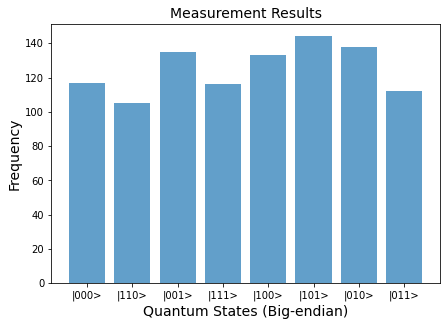

In [12]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results3.keys(), results3.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()

# Four Qubit System


In [13]:
circuit4 = QuantumCircuit(4)

In [14]:
# A simple circuit

program = [{ "gate": "H", "target": [0] },
           { "gate": "H", "target": [1] },
           { "gate": "H", "target": [2] },
           { "gate": "CNOT","target": [0,1]},
           { "gate": "CNOT","target": [0,3]},
           { "gate": "CNOT","target": [0,3]},
           { "gate": "CNOT","target": [1,2]},
           { "gate": "CNOT","target": [2,0]},
           { "gate": 'X',"target": [0]}
          ]

In [15]:
# Obtain the Standard basis for 4-qubit system
circuit4.get_std_basis()

['|0000>',
 '|0001>',
 '|0010>',
 '|0011>',
 '|0100>',
 '|0101>',
 '|0110>',
 '|0111>',
 '|1000>',
 '|1001>',
 '|1010>',
 '|1011>',
 '|1100>',
 '|1101>',
 '|1110>',
 '|1111>']

In [16]:
final_state = circuit4.get_finalstate(program) #use groundstate as initial state
print(final_state)

[[0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]
 [0.35355339+0.j]
 [0.        +0.j]]


In [17]:
results4 = circuit4.get_counts(final_state,shots=1024)
print(results4)

{'|0000>': 124, '|1000>': 121, '|1010>': 119, '|0100>': 132, '|0110>': 140, '|1110>': 125, '|0010>': 123, '|1100>': 140}


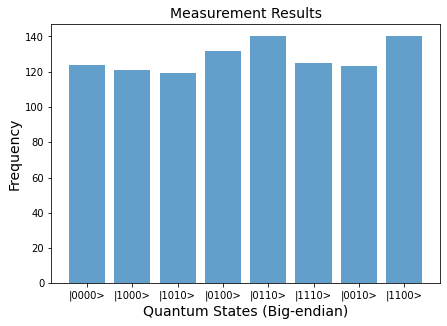

In [18]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.bar(results4.keys(), results4.values(),alpha=0.7)
ax.set_xlabel('Quantum States (Big-endian)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_title('Measurement Results',fontsize=14)
plt.show()

Thank you ! 

Some References that I found very helpful : 

1. https://qiskit.org/textbook/ch-states/single-qubit-gates.html
2. https://docs.python.org/3/library/typing.html